# Convolutional Neural Network (LeNet)
We constructed a multilayer percetron with a single hidden layer model to classify Fashion-MNIST dataset images. Each image has a width and height of 28 pixel. we expand the image, and get a vector with length of 784. Then input this vector into the fully connectional layer.  
However, this classification method has certain limitation.  
1. *Adjacent pixels in this vector may be far apart in the original image.*
2. *For big size image, using fully connnectional layer will cause the model too big, which will lead to complex model and excessive storage overhead.*

Convolutional neural network has sloved this two questions.  
1. *For one thing, it presever the shape of input.*
2. *For another, repeat calculation between same convolutional kernel and different position using sliding window to avoid the model size too big.*

Here we will introduce the `LeNet`, which is to recognize the handwritten digital images in early phase.

## LeNet Model
`LeNet` is divided into two part: **convolutional layer part** and **fully connectional layer part**.    
The basic unit in convolutional layer part is **convolutional layer followed by the maximum pooling layer.** Convolutional layer is to **recognize the spatial pattern** in image such lines and the part of object. Maximum pooling layer is to **reduce the sensitivity of convolutional layer to position.**  
Each convolutional layer use $5\times5$ window and sigmoid activation in output.

In [1]:
from mxnet import nd, gluon, autograd, init
import mxnet as mx
from mxnet.gluon import loss as gloss, nn
import d2lzh as d2l
import time

In [2]:
net = nn.Sequential()
net.add(nn.Conv2D(channels=6, kernel_size=5, activation='sigmoid'),
       nn.MaxPool2D(pool_size=2, strides=2),
       nn.Conv2D(channels=16, kernel_size=5, activation='sigmoid'),
       nn.MaxPool2D(pool_size=2, strides=2),
        # Dense will transform
        # (batch, channel, height, width) => (batch, channel * height * width)
       nn.Dense(120, activation='sigmoid'), 
       nn.Dense(84, activation='sigmoid'),
       nn.Dense(10))

In [3]:
X = nd.random.uniform(shape=(1, 1, 28, 28))
net.initialize()
for layer in net:
    X = layer(X)
    print(layer.name, 'output shape \t', X.shape)

conv0 output shape 	 (1, 6, 24, 24)
pool0 output shape 	 (1, 6, 12, 12)
conv1 output shape 	 (1, 16, 8, 8)
pool1 output shape 	 (1, 16, 4, 4)
dense0 output shape 	 (1, 120)
dense1 output shape 	 (1, 84)
dense2 output shape 	 (1, 10)


## Train Model

In [4]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [5]:
def try_gpu():
    try:
        ctx = mx.gpu()
        _ = nd.zeros((1), ctx=ctx)
    except mx.base.MXNetError:
        ctx = mx.cpu()
    return ctx
ctx = try_gpu()
ctx

gpu(0)

In [6]:
def evaluate_accuracy(data_iter, net, ctx):
    acc_sum, n = nd.array([0], ctx=ctx), 0
    for X, y in data_iter:
        X, y = X.as_in_context(ctx), y.as_in_context(ctx).astype('float32')
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.size
    return acc_sum.asscalar() / n

In [11]:
def train_ch5(net, train_iter, test_iter, batch_size, trainer, ctx, num_epochs):
    print('training on ', ctx)
    loss = gloss.SoftmaxCrossEntropyLoss()
    for epoch in range(num_epochs):
        train_l_num, train_acc_num, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X, y = X.as_in_context(ctx), y.as_in_context(ctx)
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y).sum()
            l.backward()
            trainer.step(batch_size)
            y = y.astype('float32')
            train_l_num += l.asscalar()
            train_acc_num += (y_hat.argmax(axis=1) == y).sum().asscalar()
            n += y.size
        test_acc = evaluate_accuracy(test_iter, net, ctx)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f,'
              'time %.1f sec'
             %(epoch + 1, train_l_num/n, train_acc_num/n, test_acc, time.time() - start))

In [18]:
lr, num_epochs = 0.005, 10
net.initialize(force_reinit=True, ctx=ctx, init=init.Xavier())
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})

train_ch5(net, train_iter, test_iter, batch_size, trainer, ctx, num_epochs)

training on  gpu(0)
epoch 1, loss 1.2096, train acc 0.551, test acc 0.734,time 6.0 sec
epoch 2, loss 0.5893, train acc 0.769, test acc 0.786,time 6.0 sec
epoch 3, loss 0.4802, train acc 0.816, test acc 0.828,time 6.0 sec
epoch 4, loss 0.4156, train acc 0.845, test acc 0.856,time 6.0 sec
epoch 5, loss 0.3805, train acc 0.859, test acc 0.861,time 6.0 sec
epoch 6, loss 0.3559, train acc 0.868, test acc 0.876,time 6.0 sec
epoch 7, loss 0.3334, train acc 0.876, test acc 0.877,time 6.0 sec
epoch 8, loss 0.3142, train acc 0.883, test acc 0.883,time 6.0 sec
epoch 9, loss 0.3057, train acc 0.886, test acc 0.878,time 6.0 sec
epoch 10, loss 0.2943, train acc 0.891, test acc 0.885,time 6.0 sec


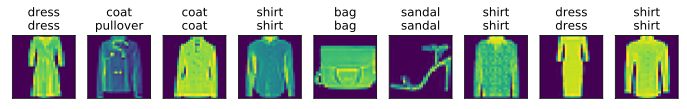

In [27]:
for X, y in test_iter:
    break
true_lables = d2l.get_fashion_mnist_labels(y.asnumpy())
pred_lables = d2l.get_fashion_mnist_labels(net(X.as_in_context(ctx)).argmax(axis=1).asnumpy())
title = [true + '\n' + pred for true, pred in zip(true_lables, pred_lables)]

d2l.show_fashion_mnist(X[10:19], title[10:19])